In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.metrics import brier_score

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import pycox
import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv


from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)


Text(0.5, 0, 'time $t$')

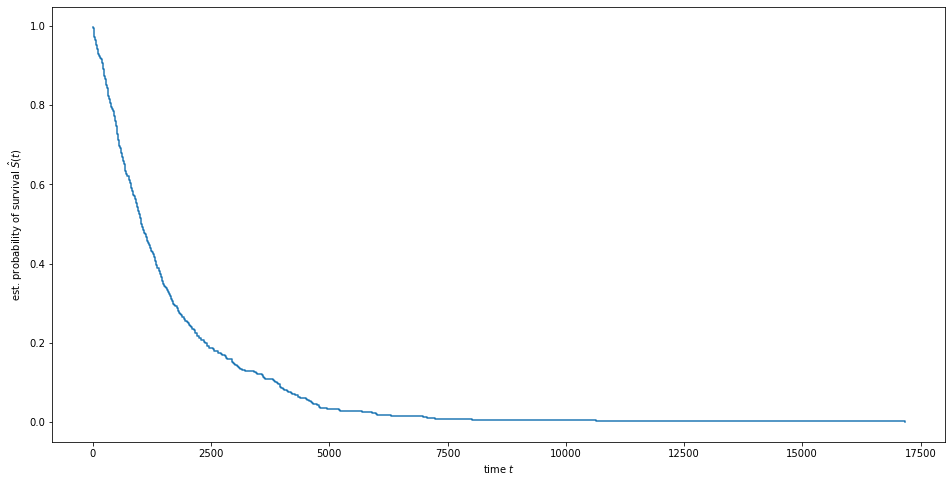

In [46]:
alpha = 0.001
beta = 1
uniform_sample = np.random.uniform(size = 600)
feature = np.random.uniform(size = 600)

feature_func = - np.sin(beta*feature)
survival_times_exp = -np.log(uniform_sample)/(alpha*np.exp(feature_func))
data = pd.DataFrame({"survival_time":survival_times_exp,"observed_death":True,"feature1":feature})
data["label_tup"] = data[["observed_death","survival_time"]].apply(tuple,axis=1)
train_data = data[:500]
test_data = data[500:550]
val_data = data[550:]

time, survival_prob = kaplan_meier_estimator(train_data["observed_death"], train_data["survival_time"])
plt.subplots(figsize = (16,8))
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [47]:
cols_standardize = ['feature1']
cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(train_data).astype('float32')
x_test = x_mapper.transform(test_data).astype('float32')
x_val = x_mapper.transform(val_data).astype('float32')

y_simu_train = np.array(train_data.label_tup.values,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
y_simu_test = np.array(test_data.label_tup.values,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
y_simu_val = np.array(val_data.label_tup.values,dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

get_target = lambda df: (df['survival_time'].values, df['observed_death'].values)
y_train_nn = get_target(train_data)
durations_test, events_test = get_target(test_data)
y_val = get_target(val_data)
val = x_val, y_val



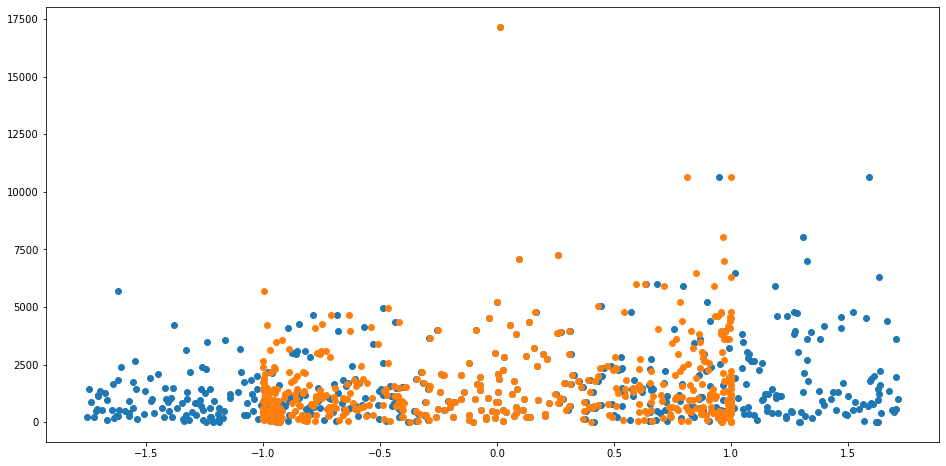

In [48]:
plt.subplots(figsize = (16,8))
scat = plt.scatter(x_train,train_data["survival_time"])
scat2 = plt.scatter(np.sin(x_train),train_data["survival_time"])

In [49]:

estimator = CoxPHSurvivalAnalysis()
estimator.fit(x_train, y_simu_train)
pd.Series(estimator.coef_, index=["feature1"])



feature1   -0.231607
dtype: float64

Text(0.5, 0, 'time $t$')

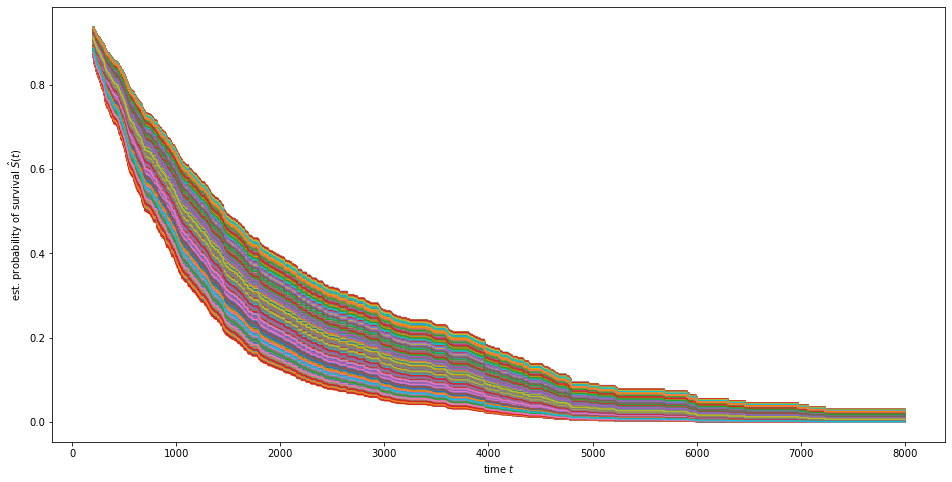

In [50]:
pred_surv = estimator.predict_survival_function(x_train)
time_points = np.arange(200, 8000)
plt.subplots(figsize = (16,8))
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")



Concordance Index is: 0.6057142857142858


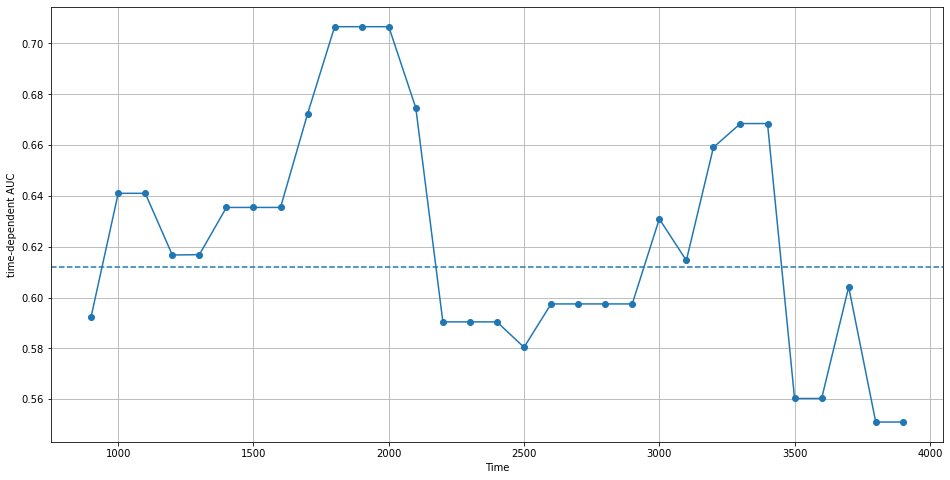

In [51]:
va_times = np.arange(900, 4000, 100)
cph_risk_scores = estimator.predict(x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    y_simu_train, y_simu_test, cph_risk_scores, va_times
)

concordance_ind = concordance_index_censored(test_data["observed_death"], test_data["survival_time"], cph_risk_scores)
print("Concordance Index is: " + str(concordance_ind[0]))

plt.subplots(figsize = (16,8))
plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Time")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [52]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model = CoxPH(net, tt.optim.Adam)



0.08902150854450441

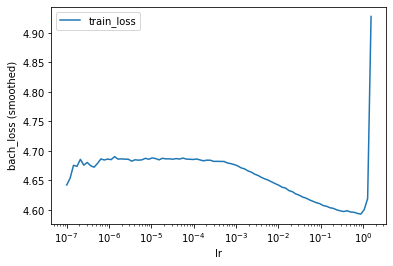

In [53]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train_nn, batch_size, tolerance=10)
_ = lrfinder.plot()

lrfinder.get_best_lr()

In [54]:
model.optimizer.set_lr(0.09)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [55]:
log = model.fit(x_train, y_train_nn, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.8732,	val_loss: 3.0614
1:	[0s / 0s],		train_loss: 4.7635,	val_loss: 2.9117
2:	[0s / 0s],		train_loss: 4.6072,	val_loss: 3.0540
3:	[0s / 0s],		train_loss: 4.6707,	val_loss: 2.9352
4:	[0s / 0s],		train_loss: 4.5885,	val_loss: 3.0913
5:	[0s / 0s],		train_loss: 4.6074,	val_loss: 2.9606
6:	[0s / 0s],		train_loss: 4.5515,	val_loss: 2.8720
7:	[0s / 0s],		train_loss: 4.5715,	val_loss: 2.8757
8:	[0s / 0s],		train_loss: 4.5451,	val_loss: 2.8945
9:	[0s / 0s],		train_loss: 4.5231,	val_loss: 2.9397
10:	[0s / 0s],		train_loss: 4.5315,	val_loss: 2.9467
11:	[0s / 0s],		train_loss: 4.5307,	val_loss: 2.9191
12:	[0s / 0s],		train_loss: 4.5263,	val_loss: 2.8939
13:	[0s / 0s],		train_loss: 4.5251,	val_loss: 2.8852
14:	[0s / 0s],		train_loss: 4.5154,	val_loss: 2.8890
15:	[0s / 0s],		train_loss: 4.5232,	val_loss: 2.9098
16:	[0s / 0s],		train_loss: 4.5129,	val_loss: 2.9286


-2.8720481395721436

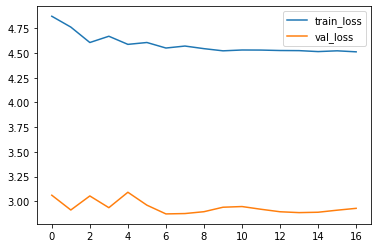

In [56]:
_ = log.plot()
model.partial_log_likelihood(*val).mean()

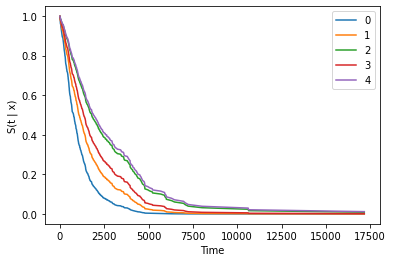

In [57]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')


(50, 500)

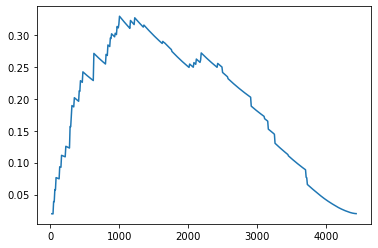

In [58]:
time_grid = np.linspace(durations_test.min()+1, durations_test.max()-1, 500)
times, score =brier_score(y_simu_train,y_simu_test,surv.transpose().values,time_grid)
plt.plot(times,score)



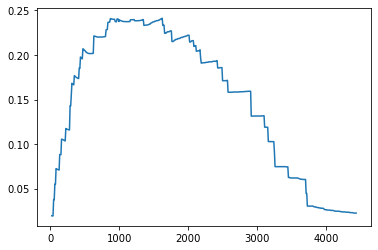

In [59]:
pred_surv = estimator.predict_survival_function(x_test)
predictions = []
for i, surv_func in enumerate(pred_surv):
    predictions.append(surv_func(time_grid))
predictions = np.array(predictions)
times, score =brier_score(y_simu_train,y_simu_test,predictions,time_grid)
plt.plot(times,score)

In [44]:
predictions.shape

(50, 500)

In [16]:
data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

In [17]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [21]:
y_simu_train

array([( True, 2.20064133e+03), ( True, 1.94138045e+01),
       ( True, 1.27706407e+04), ( True, 1.55614165e+02),
       ( True, 1.43678091e+03), ( True, 2.91371624e+03),
       ( True, 4.31325118e+02), ( True, 1.14714086e+02),
       ( True, 2.50404261e+03), ( True, 2.97948039e+02),
       ( True, 1.79799387e+02), ( True, 1.04886588e+03),
       ( True, 2.03610644e+03), ( True, 4.46698774e+01),
       ( True, 9.15604070e+01), ( True, 2.95406680e+02),
       ( True, 1.47430579e+04), ( True, 2.57312681e+02),
       ( True, 3.62529093e+03), ( True, 6.62036704e+02),
       ( True, 2.95226286e+03), ( True, 6.25904296e+02),
       ( True, 4.72908571e+03), ( True, 4.56913466e+02),
       ( True, 1.21854624e+02), ( True, 2.68030644e+03),
       ( True, 4.81974917e+03), ( True, 3.44059831e+03),
       ( True, 1.26870574e+03), ( True, 2.80227681e+02),
       ( True, 5.51299472e+03), ( True, 2.97335729e+00),
       ( True, 1.58930417e+03), ( True, 1.67708862e+02),
       ( True, 2.08782037e+02),

In [18]:
data["label_tup"].values

array([(True, 963.0693567492178), (True, 159.66271128662828),
       (True, 28.077315377693512), (True, 1842.394821327207),
       (True, 1919.1101436722379), (True, 937.036626382503),
       (True, 1099.7738732651817), (True, 786.815425854323),
       (True, 57.58037894923035), (True, 1997.165058628946),
       (True, 159.130338680901), (True, 651.9149570819276),
       (True, 85.24018840886465), (True, 5678.3865923296935),
       (True, 129.2114884586752), (True, 0.30422775686569364),
       (True, 0.5434506996789289), (True, 604.5622082196521),
       (True, 253.5116816363877), (True, 1381.480568388595),
       (True, 373.2109516399165), (True, 2715.459767045093),
       (True, 2702.3713498459447), (True, 3669.848719391555),
       (True, 2843.75424294468), (True, 1194.0911319916204),
       (True, 295.0233156569736), (True, 808.0004346777295),
       (True, 561.4041827819094), (True, 2052.783055404509),
       (True, 1438.6838549750012), (True, 3140.0543561404634),
       (True, 37